In [45]:
using LinearAlgebra
using Plots
using Vec

gr()

Plots.GRBackend()

In [46]:
# Generic function that for a will run a given number of descent steps for any descent method

function run_descent_method(descent_method, initial_point, steps, f, df)
    
    current_point = initial_point
    pointsX = [initial_point[1]]
    pointsY = [initial_point[2]]
    
    for i in 1 : steps
        current_step = step!(descent_method, df, current_point)
        push!(pointsX, current_step[1])
        push!(pointsY, current_step[2])
        current_point = current_step
    end
    return pointsX, pointsY
end

run_descent_method (generic function with 1 method)

# Question 1

Implement the step function for gradient descent within the step function below

In [47]:
abstract type DescentMethod end

In [48]:
struct GradientDescent <: DescentMethod
    learning_rate # learning rate
end

# Implement this function
function step!(self::GradientDescent, df, current_point)
    gradient = df(current_point...)
    return current_point - self.learning_rate * gradient
end

step! (generic function with 4 methods)

# Question 2

Given the function below, how do different learning rates affect the convergance performance of gradient descent in 100 steps. Which learning rate performs the best?

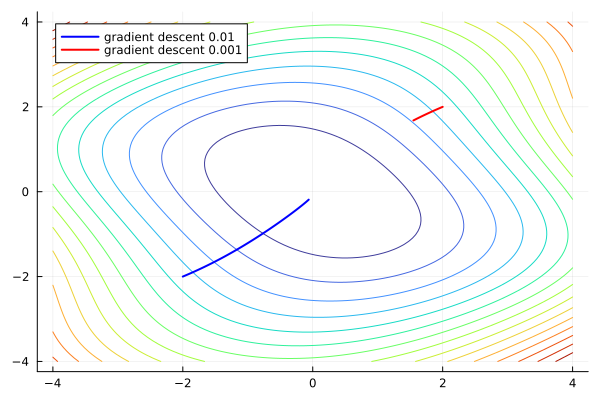

In [49]:
f(x,y) = x^2 + y^2 + x*sin(y)
df(x,y) = [
    2x + sin(y);
    2y + x*cos(y)
]

xDomain = range(-4, 4, length=100)
yDomain = range(-4, 4, length=100)
zFill = @. f(xDomain', yDomain)
    
# Tuple to store different descent methods which is looped through and plotted
# Format for tuple is {descent type, label for graph, colour for graph, 
#                      number of steps, starting point}
descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (GradientDescent(0.01), "gradient descent 0.01", "blue", 100, (-2,-2)))
push!(descent_methods, (GradientDescent(0.001), "gradient descent 0.001", "red", 100, (2,2)))

plots = contour(xDomain, yDomain, zFill,cbar=false,color=:turbo,lw=1)
    
for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
    pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
    plot!(pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
end 
plot(plots)


# Question 3

Implement the step function for gradient descent with momentum within the step function below. Compare its performance to gradient descent without momentum. How do different learning decay and rates affect the performance? 

In [50]:
mutable struct Momentum <: DescentMethod
    learning_rate # learning rate
    momentum_decay # momentum decay
    momentum # momentum
end

# Implement this function
function step!(self::Momentum, df, current_point)
    gradient = df(current_point...)
    new_momentum = self.momentum_decay * self.momentum - self.learning_rate * gradient
    self.momentum = new_momentum
    new_point = current_point + new_momentum
    return new_point
end

step! (generic function with 4 methods)

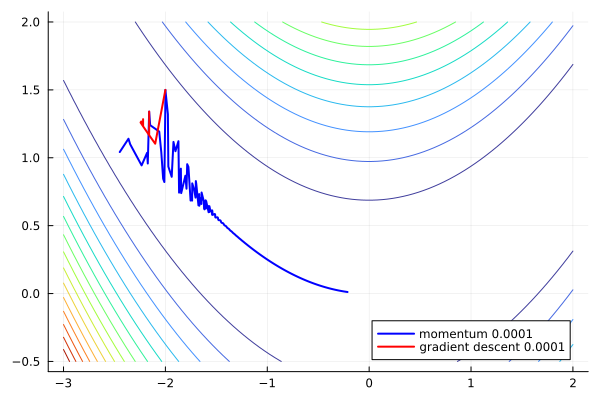

In [51]:
f(x,y) = (1-x)^2 + 100*(4y - x^2)^2
df(x, y) = [
    -2(1-x) - 400*x*(4y - x^2),
    800*(4y - x^2)
]

xDomain = range(-3, 2, length=100)
yDomain = range(-0.5, 2, length=100)
zFill = @. f(xDomain', yDomain)

descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (Momentum(0.0001, 0.9, zeros(2)), "momentum 0.0001", "blue", 500, (-2,1.5)))
push!(descent_methods, (GradientDescent(0.0001), "gradient descent 0.0001", "red", 500, (-2,1.5)))

plots = contour(xDomain, yDomain, zFill,cbar=false,color=:turbo,lw=1)
 
for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
    pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
    plot!(pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
end

plot(plots)

# Question 4

Implement the step function for gradient descent with Nesterov momentum within the step function below. Compare its performance to gradient descent with momentum. How do different learning decay rates affect the performance?

In [52]:
mutable struct NesterovMomentum <: DescentMethod
    learning_rate # learning rate
    momentum_decay # momentum decay
    momentum # momentum
end


# Implement this function
function step!(self::NesterovMomentum, df, current_point)
    projected_point = current_point + self.momentum_decay * self.momentum
    gradient = df(projected_point...)
    new_momentum = self.momentum_decay * self.momentum - self.learning_rate * gradient
    new_point = current_point + new_momentum
    self.momentum = new_momentum
    return new_point
end

step! (generic function with 4 methods)

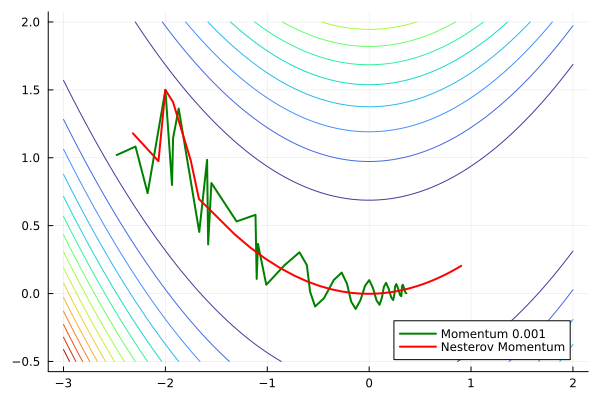

In [53]:
f(x,y) = (1-x)^2 + 100*(4y - x^2)^2
df(x,y) = [
    -2(1-x) - 400*x*(4y - x^2),
    800*(4y - x^2)    
]

xDomain = range(-3, 2, length=100)
yDomain = range(-0.5, 2, length=100)
zFill = @. f(xDomain', yDomain)

descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (Momentum(0.0003, 0.9, zeros(2)), "Momentum 0.001", "green",50,(-2,1.5)))
push!(descent_methods, (NesterovMomentum(0.0002, 0.92, zeros(2)), "Nesterov Momentum", "red",50,(-2,1.5)))

plots = contour(xDomain, yDomain, zFill,cbar=false,color=:turbo,lw=1)
    
for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
    pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
    plot!(pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
end 
plot(plots)

# Question 5

Implement the step function for Adagrad. Compare its performance to momentum and Nesterov momentum. How do different learning rates and epsilon values affect the performance?

In [54]:
mutable struct Adagrad <: DescentMethod
    learning_rate
    epsilon
    sum_gradients

    function Adagrad(learning_rate::Float64, epsilon::Float64, dim::Vector{Float64})
        sum_gradients = dim 
        new(learning_rate, epsilon, sum_gradients)
    end
end

# Implement this function
function step!(self::Adagrad, df, current_point)
    gradient = df(current_point...)
    push!(self.sum_gradients, dot(gradient, gradient))
    sum_grad_sqrt = sqrt(sum(self.sum_gradients))
    return current_point - self.learning_rate / (self.epsilon + sum_grad_sqrt) * gradient
end

step! (generic function with 4 methods)

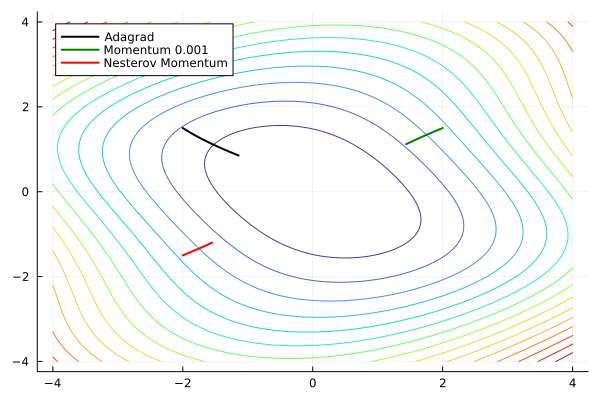

In [55]:
f(x,y) = x^2 + y^2 + x*sin(y)
df(x,y) = [
    2x + sin(y);
    2y + x*cos(y)
]

xDomain = range(-4, 4, length=100)
yDomain = range(-4, 4, length=100)
zFill = @. f(xDomain', yDomain)

descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (Adagrad(0.1, 1e-6, zeros(2)), "Adagrad", "black",50,(-2,1.5)))
push!(descent_methods, (Momentum(0.0003, 0.9, zeros(2)), "Momentum 0.001", "green",50,(2,1.5)))
push!(descent_methods, (NesterovMomentum(0.0002, 0.92, zeros(2)), "Nesterov Momentum", "red",50,(-2,-1.5)))
plots = contour(xDomain, yDomain, zFill,cbar=false,color=:turbo,lw=1)
    
for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
    pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
    plot!(pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
end 
plot(plots)

# Question 6

Compare how Gradient Descent, Momentum, Nesterov Momentum, Adagrad and ADAM perform on the following function

In [73]:
mutable struct Adam <: DescentMethod
    learning_rate # learning rate
    decay_v # decay_v
    decay_s # decay_s
    epsilon # small value
    counter # step counter
    v # 1st moment estimate
    s # 2nd moment estimate
end

# Implement this function
function step!(self::Adam, df, current_point)
    gradient = df(current_point...)
    new_v = self.decay_v * self.v + (1 - self.decay_v) * gradient
    new_s = self.decay_s * self.s + (1 - self.decay_s) * (gradient .* gradient)

    v_hat = new_v / (1 - self.decay_v)
    s_hat = new_s / (1 - self.decay_s)

    self.v = new_v
    self.s = new_s
    self.counter += 1

    return current_point - self.learning_rate * v_hat ./ (self.epsilon .+ sqrt.(s_hat))
end

step! (generic function with 5 methods)

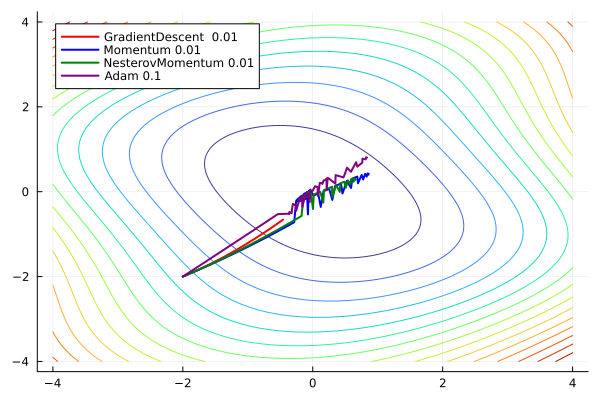

In [74]:
f(x,y) = x^2 + y^2 + x*sin(y)
df(x,y) = [
    2x + sin(y);
    2y + x*cos(y)
]

xDomain = range(-4, 4, length=100)
yDomain = range(-4, 4, length=100)
zFill = @. f(xDomain', yDomain)
    
# Tuple to store different descent methods which is looped through and plotted
# Format for tuple is {descent type, label for graph, colour for graph, 
#                      number of steps, starting point}
descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (GradientDescent(0.01), "GradientDescent  0.01", "red", 50, (-2,-2)))
push!(descent_methods, (Momentum(0.01,0.9,zeros(2)), "Momentum 0.01", "blue", 50, (-2,-2)))
push!(descent_methods, (NesterovMomentum(0.01,0.9,zeros(2)), "NesterovMomentum 0.01", "green", 50, (-2,-2)))
push!(descent_methods, (Adam(0.1, 0.9, 0.9, 1e-8, 0, zeros(2), zeros(2)), "Adam 0.1", "purple",50,(-2,-2)))

plots = contour(xDomain, yDomain, zFill,cbar=false,color=:turbo,lw=1)
    
for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
    pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
    plot!(pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
end 
plot(plots)